# Generational changes in religious affiliaton, beliefs, and attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from  https://gssdataexplorer.norc.org/extracts/21438/download

In [2]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Question 1: Interpretation of the bible https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [3]:
gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)
sum(gss.bible.isnull())

29426

In [4]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

Question 2: Confidence in the people running religious institutions https://gssdataexplorer.norc.org/projects/29853/variables/450/vshow

In [5]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.conclerg.isnull())

21554

In [6]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

Question 3: Belief in God https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [7]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [8]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

Question 4: Religious preference https://gssdataexplorer.norc.org/projects/29853/variables/287/vshow

In [9]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [10]:
utils.values(gss, 'relig')

1.0     35968
2.0     15181
3.0      1246
4.0      7254
5.0      1069
6.0       177
7.0        89
8.0        38
9.0       136
10.0      112
11.0      762
12.0       30
13.0      135
Name: relig, dtype: int64

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [11]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [12]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

Drop records if age or cohort is missing.

In [13]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(62244, 11)

We drop 222 records due to missing data.

In [14]:
62466 - 62244

222

Here's the distribution of ages.

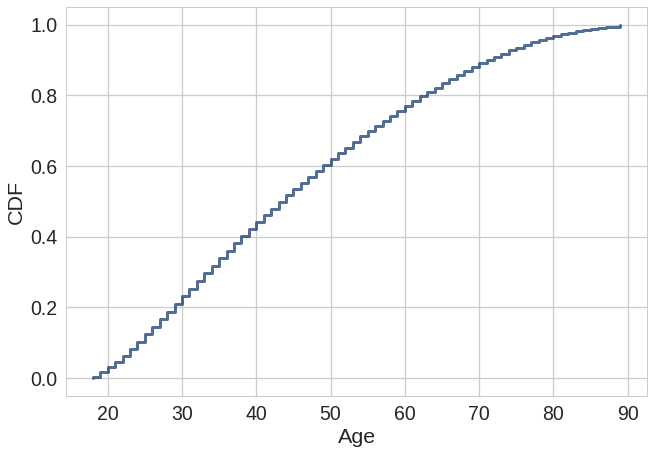

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

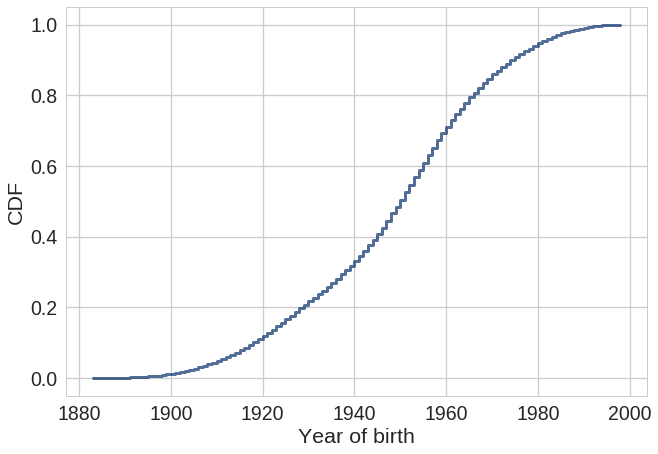

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [19]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3074
1936.5    3632
1941.5    4343
1946.5    5616
1951.5    6349
1956.5    6465
1961.5    5556
1966.5    4413
1971.5    3483
1976.5    2631
1981.5    2044
1986.5    1280
1991.5     658
1996.5     210
Name: relig, dtype: int64

In [20]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [21]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.relig.count()
counts

cohort10
1880.0       60
1890.0      607
1900.0     2046
1910.0     4126
1920.0     6016
1930.0     6878
1940.0    10320
1950.0    12891
1960.0     9530
1970.0     5819
1980.0     3034
1990.0      668
Name: relig, dtype: int64

Here's the number of respondents in each year.

In [22]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
Name: year, dtype: int64

## Recoding

Creating one-hots and categorical variables for the dependent variables.

In [23]:
def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
     # lumping "Christian" with Protestant
    df['prot'] = df.relig.isin([1,11])

    # lumping "Orthodox-Christian" with Catholic
    df['cath'] = df.relig.isin([2,10])
    df['none'] = (df.relig==4)
    df['other'] = df.relig.isin([3,5,6,7,8,9,12,13])
    
    # recoding relig4 with just 4 categories
    df['relig4'] = df.relig.copy()
    df.relig4.replace([11], 1, inplace=True)
    df.relig4.replace([10], 2, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    
    # anywhere relig is null, the recoded variables should be, too
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [24]:
sum(gss.relig.isnull())

249

In [25]:
utils.values(gss, 'relig4')

1.0    36616
2.0    15248
3.0     2900
4.0     7231
Name: relig4, dtype: int64

In [26]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    # reducing the number of categories to 3
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [27]:
sum(gss.god.isnull())

39961

In [28]:
utils.values(gss, 'belief3')

1.0     1780
2.0     6837
3.0    13666
Name: belief3, dtype: int64

In [29]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [30]:
sum(gss.conclerg.isnull())

21466

In [31]:
utils.values(gss, 'conclerg')

1.0    11329
2.0    20816
3.0     8633
Name: conclerg, dtype: int64

In [32]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['literal'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    varnames = ['literal', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [33]:
sum(gss.bible.isnull())

29291

In [34]:
utils.values(gss, 'bible')

1.0    11149
2.0    15887
3.0     5917
Name: bible, dtype: int64

In [35]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [36]:
center_factors(gss)

## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [37]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,noconf,literal,inspired,legends,ones,c,a,c2,a2,ac
0,1972,NaN,NaN,1916.0,56.0,1.3339,0,1.0,6,12,...,NaN,NaN,NaN,NaN,1.0,-50.0,9.0,2500.0,81.0,-450.0
1,1972,NaN,NaN,1916.0,56.0,0.8893,0,2.0,14,776,...,NaN,NaN,NaN,NaN,1.0,-50.0,9.0,2500.0,81.0,-450.0
2,1972,NaN,NaN,1937.0,35.0,0.8893,0,2.0,16,1461,...,NaN,NaN,NaN,NaN,1.0,-29.0,-12.0,841.0,144.0,348.0
3,1972,NaN,NaN,1952.0,20.0,0.8893,0,1.0,13,1267,...,NaN,NaN,NaN,NaN,1.0,-14.0,-27.0,196.0,729.0,378.0
4,1972,NaN,NaN,1902.0,70.0,0.8893,0,1.0,14,765,...,NaN,NaN,NaN,NaN,1.0,-64.0,23.0,4096.0,529.0,-1472.0


### Run logistic models

One relgion category at a time, as opposed to the mulinomial models below.

In [38]:
formula = 'prot ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.664888
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61965
Model:                          Logit   Df Residuals:                    61962
Method:                           MLE   Df Model:                            2
Date:                Wed, 11 Oct 2017   Pseudo R-squ.:                 0.02229
Time:                        14:37:26   Log-Likelihood:                -41200.
converged:                       True   LL-Null:                       -42139.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0270      0.014      1.864      0.062      -0.001       0.055
c             -0.0185      0.001    -28.565      0.000      -0.020      -0.017
a             -0.0015      0.001     -1.989      0.047      -0.003   -2.28e-05
==============================================================================
"""

In [39]:
age = [37, 47, 37, 47]
cohort = [1980, 1980, 1990, 1990]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [40]:
def model_predict(model, new):
    res = new.copy()
    res['pred'] = model.predict(new) * 100
    res['diff'] = res.pred - res.pred[0]
    return res[['cohort', 'age',  'pred', 'diff']]

In [41]:
model_predict(model, new)

,cohort,age,pred,diff
0,1980,37,44.620589,0.000000
1,1980,47,44.239982,-0.380607
2,1990,37,40.116846,-4.503743
3,1990,47,39.747083,-4.873506


In [42]:
formula = 'none ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.337507
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61965
Model:                          Logit   Df Residuals:                    61962
Method:                           MLE   Df Model:                            2
Date:                Wed, 11 Oct 2017   Pseudo R-squ.:                 0.06263
Time:                        14:37:27   Log-Likelihood:                -20914.
converged:                       True   LL-Null:                       -22311.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5045      0.020    -73.713      0.000      -1.544      -1.464
c              0.0410      0.001     38.823      0.000       0.039       0.043
a              0.0105      0.001      8.272      0.000       0.008       0.013
==============================================================================
"""

In [43]:
model_predict(model, new)

,cohort,age,pred,diff
0,1980,37,26.187617,0.000000
1,1980,47,28.272516,2.084899
2,1990,37,34.827844,8.640227
3,1990,47,37.253448,11.065831


In [44]:
formula = 'relig4 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.030441
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61965
Model:                        MNLogit   Df Residuals:                    61956
Method:                           MLE   Df Model:                            6
Date:                Wed, 11 Oct 2017   Pseudo R-squ.:                 0.02639
Time:                        14:37:29   Log-Likelihood:                -63851.
converged:                       True   LL-Null:                       -65582.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6987      0.017    -40.314      0.000      -0.733      -0.665
c              0.0073      0.001      9.749      0.000       0.006       0.009
a             -0.0036      0.001     -4.008      0.000      -0.005      -0.002
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1386      0.032    -66.197      0.000      -2.202      -2.075
c              0.0221      0.002     14.468      0.000       0.019       0.025
a              0.0088      0.002      4.797      0.000       0.005       0.012
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0210      0.021    -47.881      0.000      -1.063      -0.979
c              0.0445      0.001     40.856      0.000       0.042       0.047
a              0.0100      0.001      7.676      0.000       0.007       0.013
==============================================================================
"""

## Religious affiliation

In [45]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

In [46]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [47]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [48]:
grouped_year = sample.groupby(['year'])

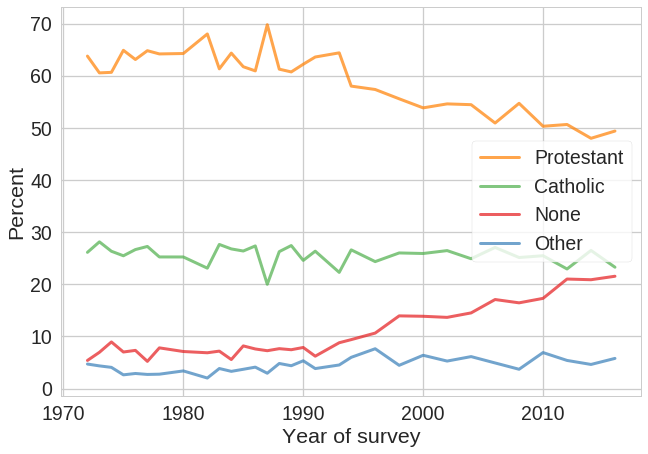

In [49]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [50]:
grouped_age = sample.groupby(['age_group'])

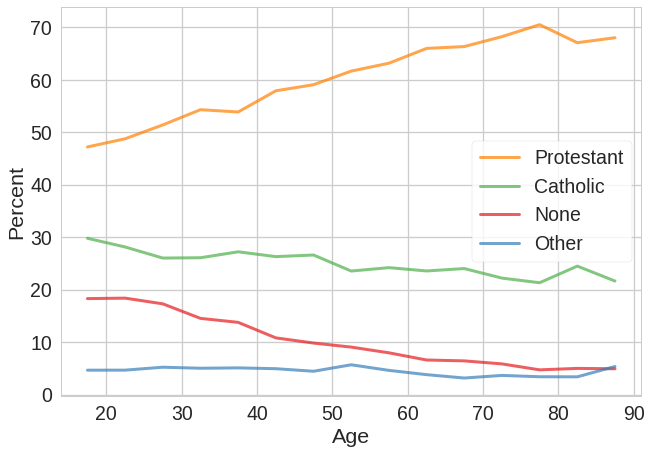

In [51]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [52]:
grouped_cohort = sample.groupby(['cohort5'])
#counts = grouped_cohort.relig.count()
#counts

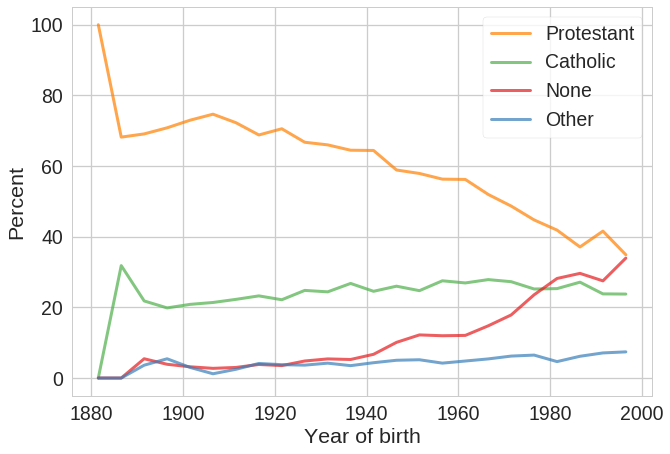

In [53]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Multinomial models

In [54]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

In [55]:
def predict_multi_model(age, model, year, factors, index):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # simplification:
    # assume that all respondents have the mean probability for
    # each category, and sample from the multinomial distribution
    #means = pred.mean(axis=0)
    #freqs0 = np.random.multinomial(n, means) / n
    
    # non-simplification: treat each row as a predictive distribution
    # and draw a sample from each row
    
    # compute cumulative probabilities along each row
    cumpred = pred.cumsum(axis=1)
    
    # generate a random value for each row and compare to the
    # cumulative probabilities
    temp = np.random.random(n)[:,None] <= cumpred
    
    # find the index of the first True in each row
    choices = temp.argmax(axis=1) + 1
    
    # compute the PMF of the choices
    _, counts = np.unique(choices, return_counts=True)
    freqs = counts / n

    return pd.Series(freqs, index=index) * 100

In [56]:
train_year = 2016
train = sample[sample.year <= train_year]

In [57]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [58]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [59]:
predict_multi_model(age, model, 1976, factors, index)

prot     65.488274
cath     26.041302
other     3.430172
none      5.040252
dtype: float64

In [60]:
predict_multi_model(age, model, 2016, factors, index)

prot     48.792440
cath     24.256213
other     6.265313
none     20.686034
dtype: float64

In [61]:
predict_multi_model(age, model, 2026, factors, index)

prot     42.807140
cath     23.031152
other     5.425271
none     28.736437
dtype: float64

In [62]:
predict_multi_model(age, model, 2036, factors, index)

prot     36.261813
cath     20.336017
other     6.475324
none     36.926846
dtype: float64

In [63]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    train_year: upper bound or (low, high) tuple for years of data
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    index: index for the resulting DataFrame
    
    returns: DataFrame that maps from index to predicted values
    """
    try:
        low, high = train_year
    except TypeError:
        low = 0
        high = train_year
        
    train = df[(df.year >= low) & (df.year <= high)]
    age = df.loc[df.year==high, 'age']
    
    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [64]:
def plot_multi_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

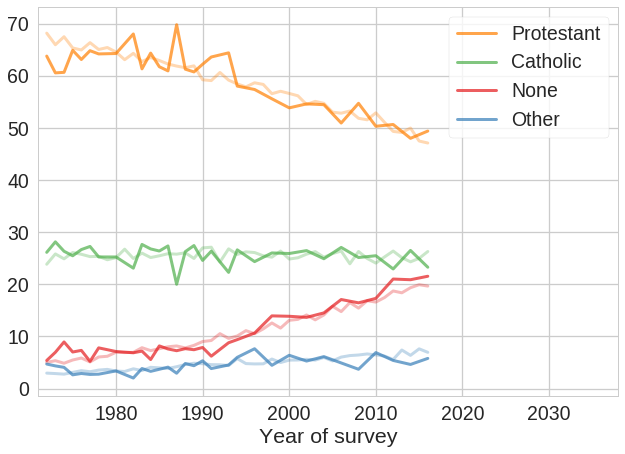

In [65]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
thinkplot.config(xlim=[1971, 2038])

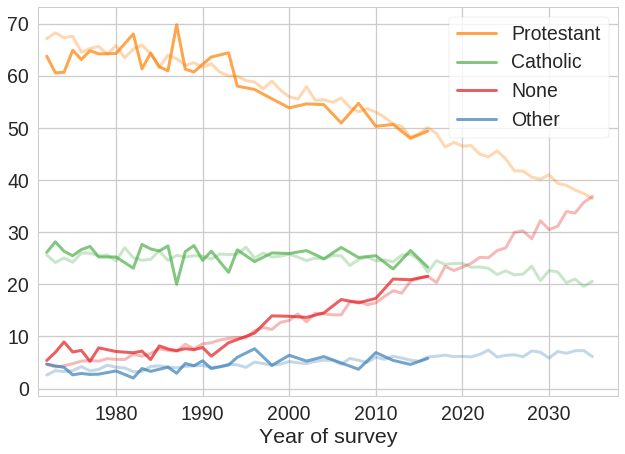

In [66]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

I don't believe in God.....................1 

I don't know whether there is a God and I don''t believe there is any way to find out..................................2

I don't believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [67]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

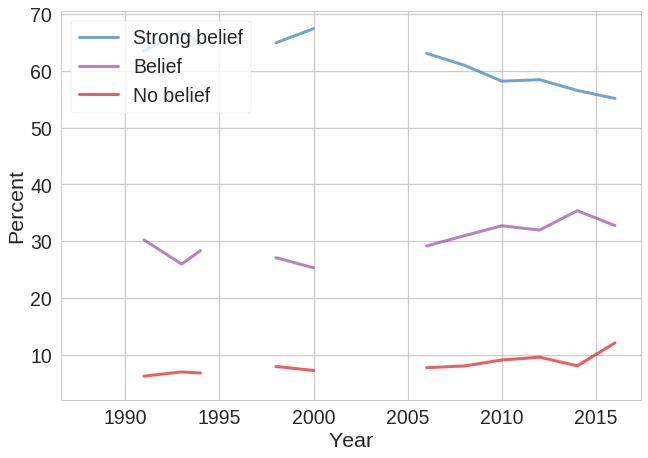

In [68]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

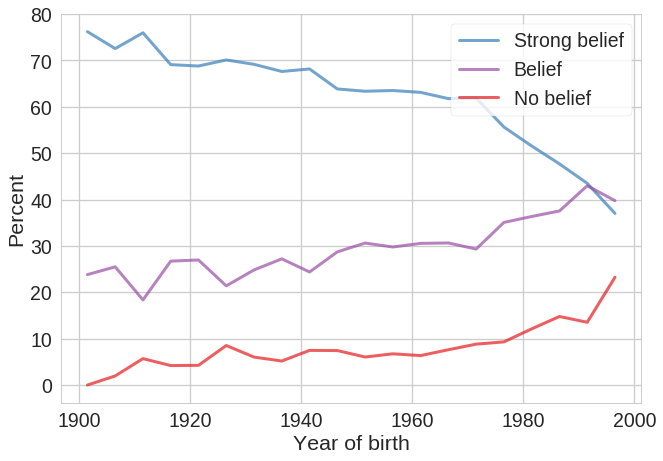

In [69]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [70]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.860076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22374
Model:                        MNLogit   Df Residuals:                    22368
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Oct 2017   Pseudo R-squ.:                 0.01132
Time:                        14:38:27   Log-Likelihood:                -19243.
converged:                       True   LL-Null:                       -19464.
                                        LLR p-value:                 4.426e-94
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2334      0.034     36.469      0.000       1.167       1.300
c             -0.0154      0.003     -5.102      0.000      -0.021      -0.010
a             -0.0076      0.003     -2.300      0.021      -0.014      -0.001
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8207      0.032     56.661      0.000       1.758       1.884
c             -0.0299      0.003    -10.383      0.000      -0.036      -0.024
a             -0.0098      0.003     -3.101      0.002      -0.016      -0.004
==============================================================================
"""

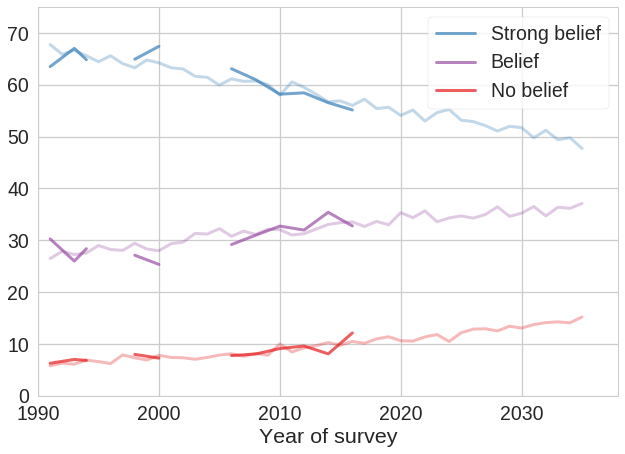

In [71]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

In [72]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,66.608330,26.776339,6.615331
2016,56.107805,34.826741,9.065453
2036,49.002450,36.226811,14.770739


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [73]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

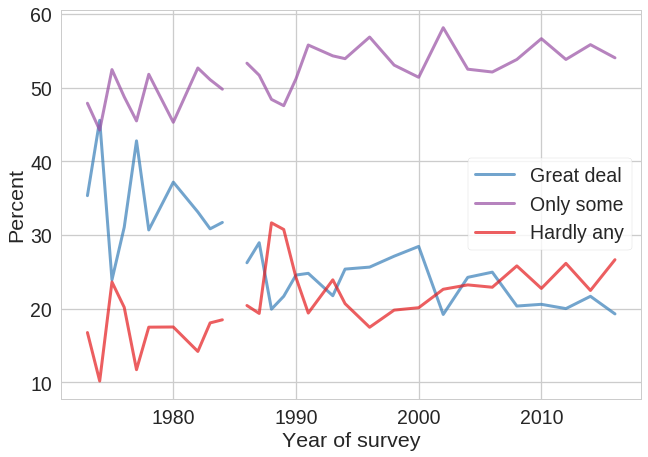

In [74]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

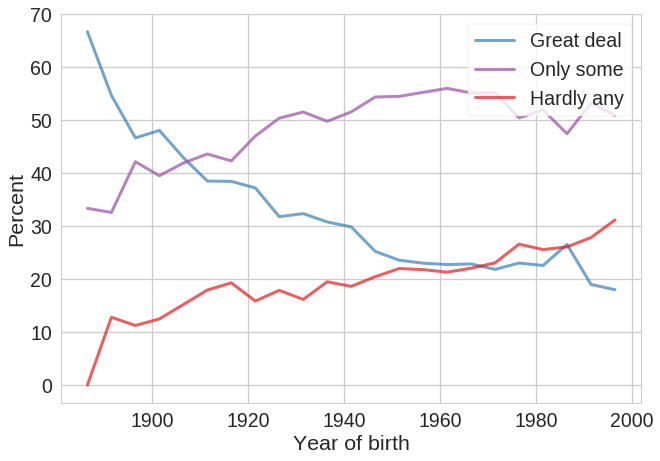

In [75]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

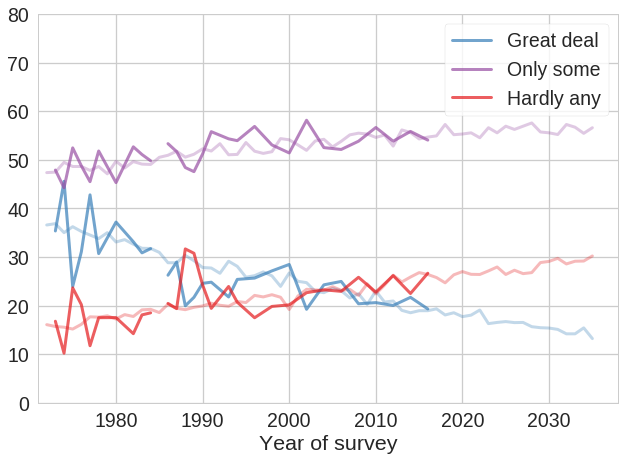

In [76]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

In [77]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,35.596780,47.357368,17.045852
2016,18.760938,55.687784,25.551278
2036,13.265663,57.822891,28.911446


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [78]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['literal', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

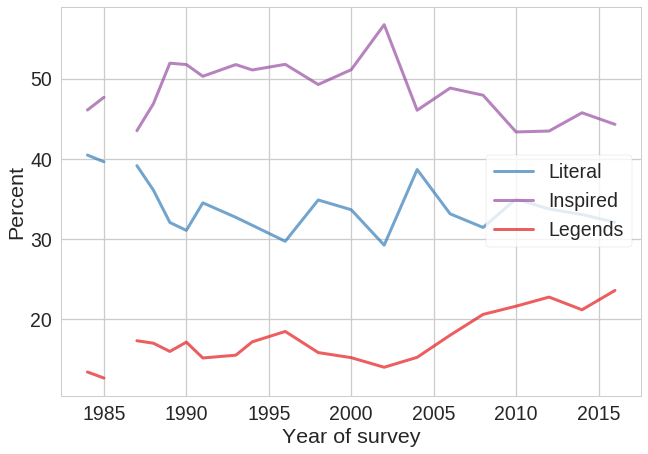

In [79]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

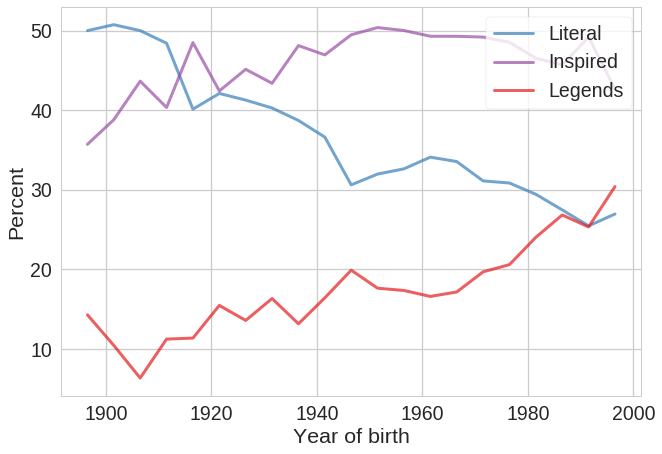

In [80]:
plot_bible(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

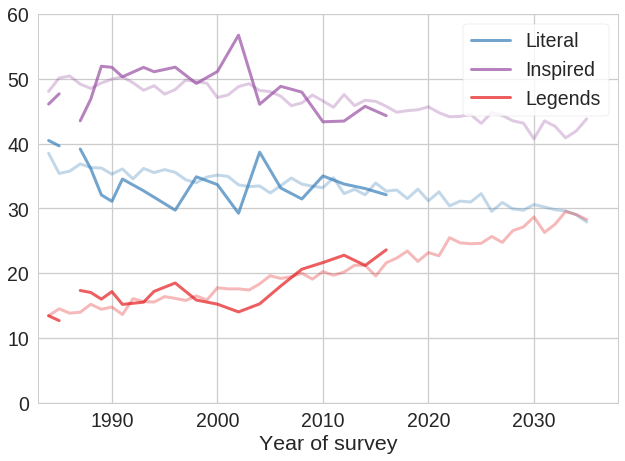

In [81]:
var = 'bible'
varnames = ['literal', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])

In [82]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,literal,inspired,legends
1986,36.751838,50.087504,13.160658
2016,32.691635,45.887294,21.421071
2036,28.946447,41.827091,29.226461


## Resampling

In [83]:
#import age_religion
#gss = age_religion.read_gss()

In [84]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [85]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [86]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [87]:
def run_data(df, groupvar, varnames, iters=101):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [88]:
def run_model(df, var, varnames, train_year, years, index, iters=101):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ['ones', 'a', 'c']

    def run():
        sample = utils.ResampleByYear(df)
        return make_multi_pred(sample, var, varnames,
                               train_year, years, factors, index)

    dfs = [run() for _ in range(iters)]
    return dfs

## Affiliation

In [131]:
groupvar = 'year'
varnames = ['prot', 'cath', 'none', 'other']

In [90]:
dfs1 = run_data(gss, groupvar, varnames, iters=101)

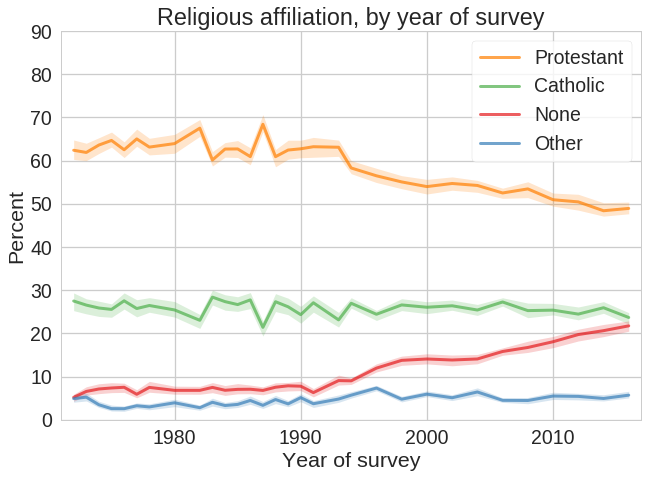

In [91]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[0, 90])

In [92]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=101)

Writing affiliation_cohort.png


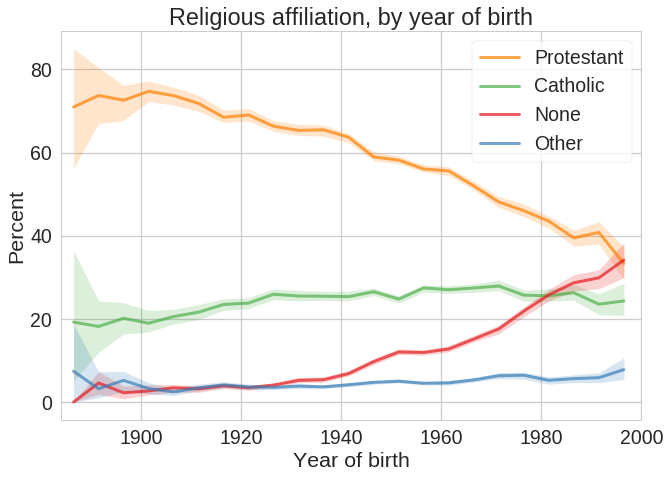

In [132]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs2, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], yim=[0, 90])

thinkplot.SaveFormat('affiliation_cohort', 'png')

Train with all data

In [134]:
var = 'relig4'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

Writing affiliation_year.png


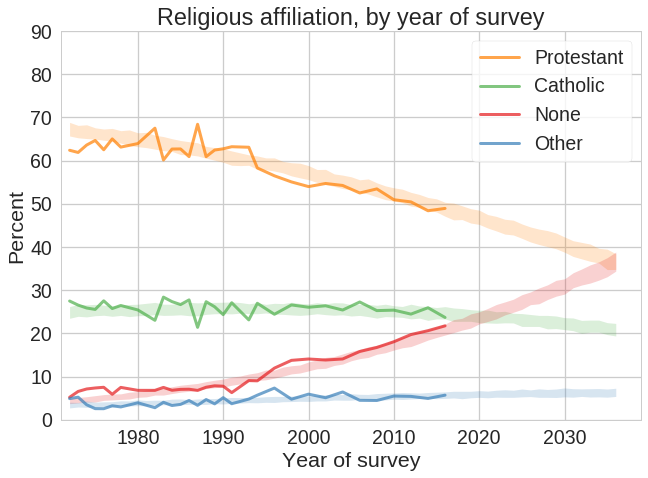

In [135]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 90])

thinkplot.SaveFormat('affiliation_year', 'png')

Train with data since 1990

In [96]:
var = 'relig4'
train_year = 1990, 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3a = run_model(gss, var, varnames, train_year, years, index, iters=101)

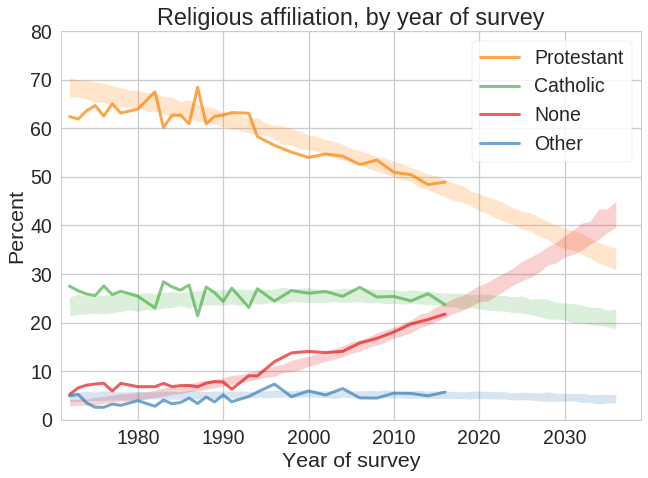

In [97]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3a, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data up to 2006

In [137]:
var = 'relig4'
train_year = 2006
factors = ['ones', 'a', 'c']

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

Writing affiliation_year_2006.png


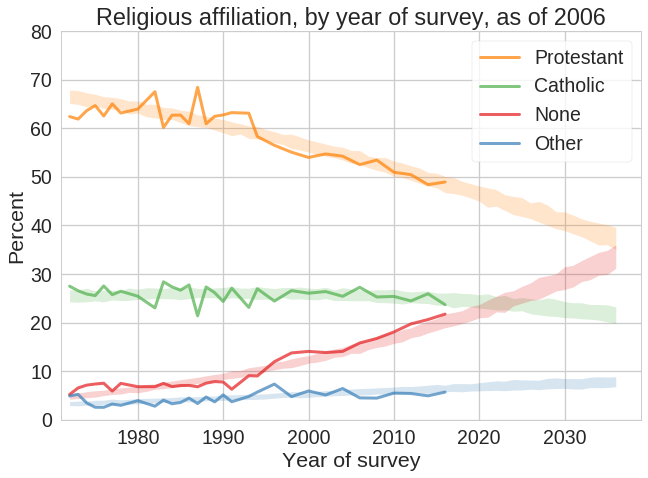

In [142]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1a, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey, as of 2006', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

thinkplot.SaveFormat('affiliation_year_2006', 'png')

Train with data up to 1996

In [100]:
train_year = 1996

dfs4a = run_model(gss, var, varnames, train_year, years, index, iters=101)

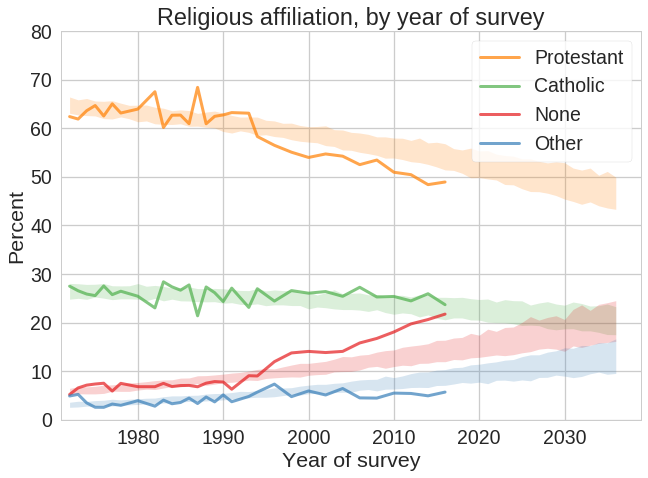

In [101]:
plot_percentiles(dfs4a, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [102]:
ps = np.array([0.5])
series_seq = [df['other'] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,4.865243
1986,5.005250
1996,5.320266
2006,5.250263
2016,5.145257


## Beliefs

In [103]:
groupvar = 'year'
varnames = ['strongbelief', 'belief', 'nobelief']

In [104]:
dfs5 = run_data(gss, groupvar, varnames, iters=101)

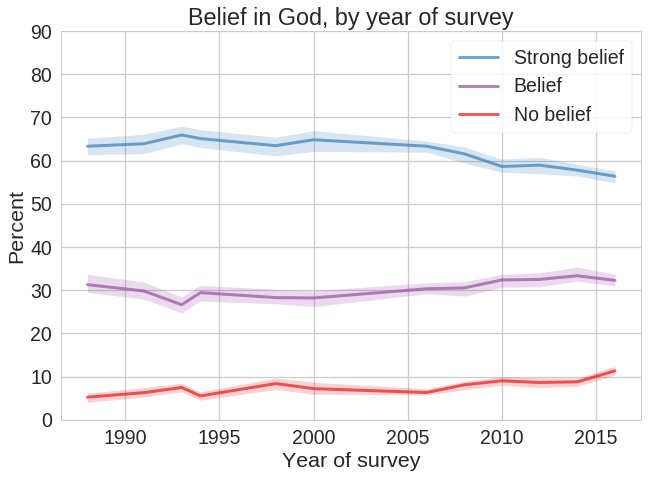

In [105]:
colors = [BLUE, PURPLE, RED]
labels = ['Strong belief', 'Belief', 'No belief']

plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 ylim=[0, 90])

In [106]:
groupvar = 'cohort5'
dfs6 = run_data(gss, groupvar, varnames, iters=101)

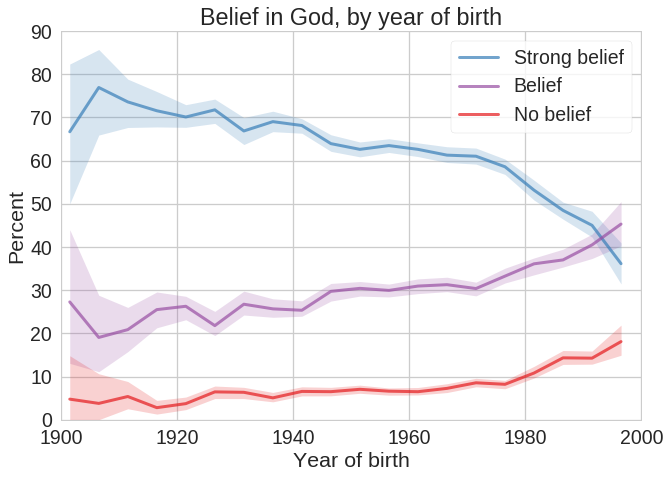

In [107]:
plot_percentiles(dfs6, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1900, 2000], ylim=[0, 90])

In [108]:
var = 'belief3'
train_year = 2016
years = np.arange(1988, 2037)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

In [109]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, iters=101)

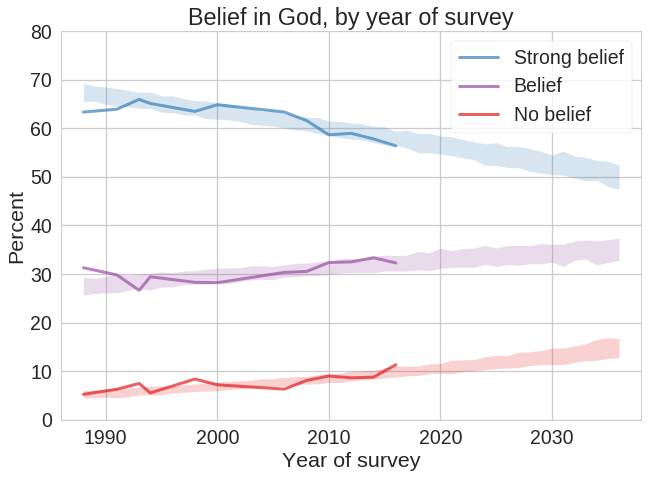

In [110]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1986, 2038], ylim=[0, 80])

In [111]:
var = 'nobelief'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,NaN
1996,6.335317
2006,7.770389
2016,9.730487
2026,11.935597
2036,14.735737


## Confidence

In [112]:
groupvar = 'year'
varnames = ['confident', 'someconf', 'noconf']

In [113]:
dfs8 = run_data(gss, groupvar, varnames, iters=101)

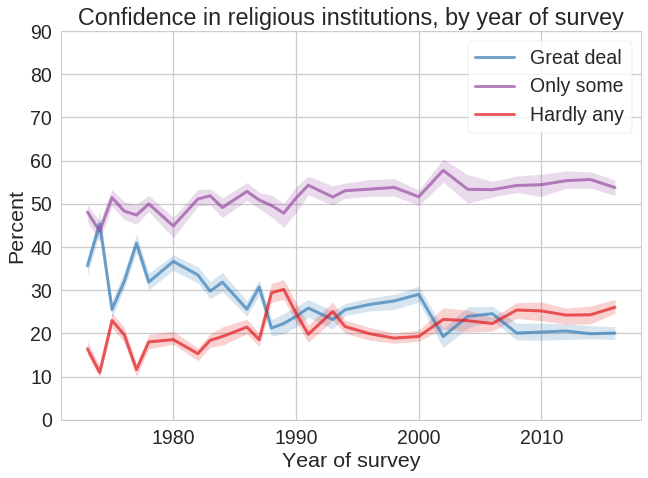

In [114]:
colors = [BLUE, PURPLE, RED]
labels = ['Great deal', 'Only some', 'Hardly any']

plot_percentiles(dfs8, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent', ylim=[0, 90])

In [115]:
groupvar = 'cohort5'
dfs9 = run_data(gss, groupvar, varnames, iters=101)

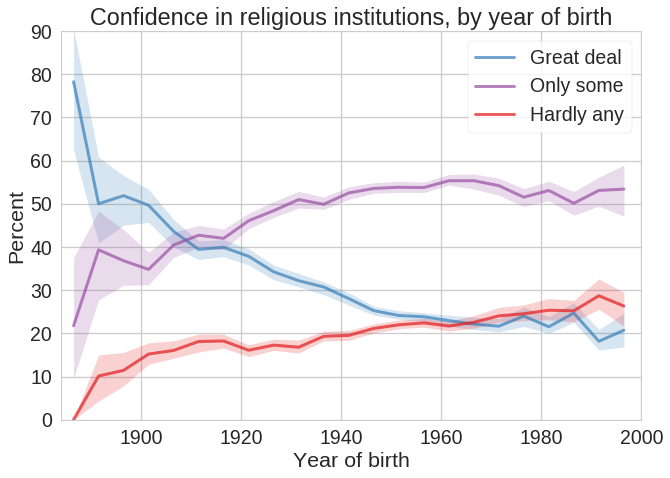

In [116]:
plot_percentiles(dfs9, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1884, 2000], ylim=[0, 90])

In [117]:
var = 'conclerg'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['confident', 'someconf', 'noconf']

In [118]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, iters=101)

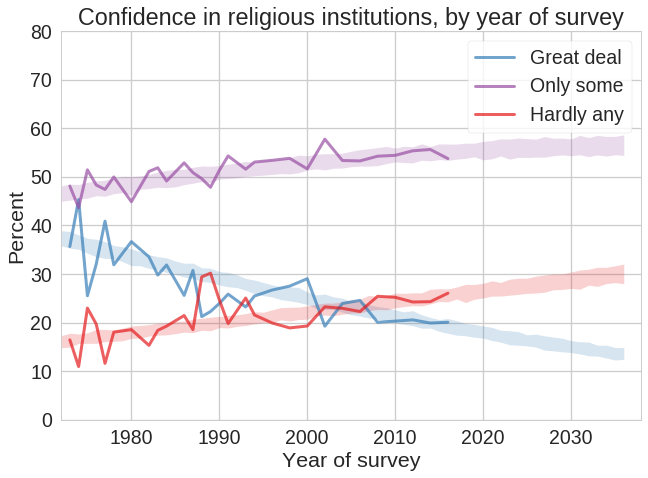

In [119]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2038], ylim=[0, 80])

In [120]:
var = 'noconf'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,17.115856
1986,19.145957
1996,21.386069
2006,23.696185
2016,25.656283
2026,27.896395
2036,29.821491


## Bible

In [121]:
groupvar = 'year'
varnames = ['inspired', 'literal', 'legends']

In [122]:
dfs11 = run_data(gss, groupvar, varnames, iters=101)

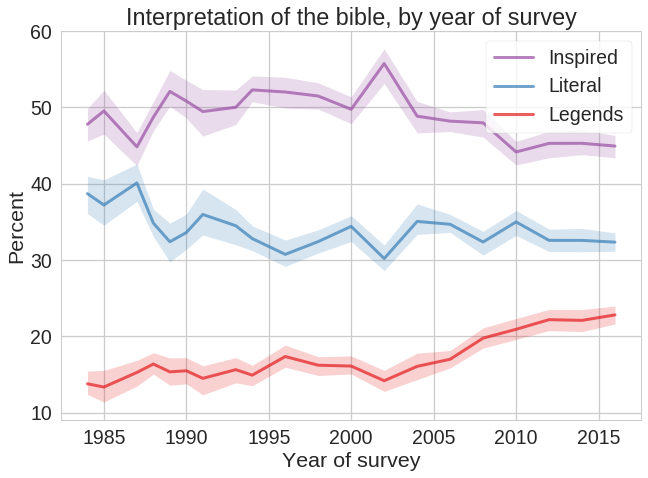

In [123]:
colors = [PURPLE, BLUE, RED]
labels = ['Inspired', 'Literal', 'Legends']

plot_percentiles(dfs11, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [124]:
groupvar = 'cohort5'
dfs12 = run_data(gss, groupvar, varnames, iters=101)

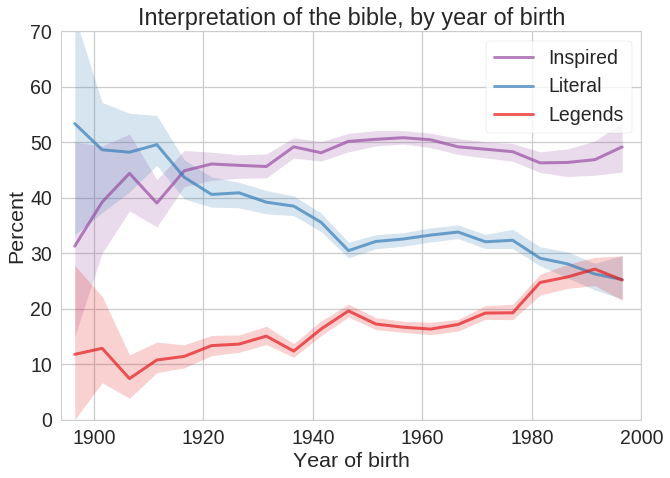

In [125]:
plot_percentiles(dfs12, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1894, 2000], ylim=[0, 70])

In [126]:
var = 'bible'
train_year = 2016
years = np.arange(1984, 2037)
factors = ['ones', 'a', 'c']
index = ['literal', 'inspired', 'legends']

In [127]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, iters=101)

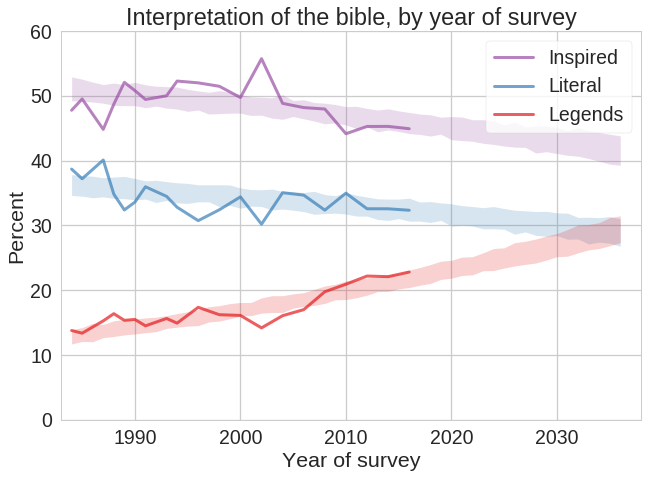

In [128]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1983, 2038], ylim=[0, 60])

In [129]:
var = 'legends'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,13.405670
1996,15.820791
2006,18.585929
2016,21.631082
2026,25.446272
2036,29.331467
